In [1]:
#!/usr/bin/env python
# coding: utf-8
import re
import sys
import pandas as pd
import sys
import ast
import matplotlib.pyplot as plt
import os
import time
import ast


global _app_name
run_command="/usr/lib/jvm/java-17-openjdk-amd64/bin/java -Dfile.encoding=UTF-8 -Dstdout.encoding=UTF-8 -Dstderr.encoding=UTF-8 -classpath /media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/_output/production/iFogSim2:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-examples-3.0.3.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/cloudsim-examples-3.0.3-sources.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/commons-math3-3.5/commons-math3-3.5.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/guava-18.0.jar:/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/jars/json-simple-1.1.1.jar -XX:+ShowCodeDetailsInExceptionMessages org.fog.test.perfeval."

_app_name="LabellingDCNS"
_report_path="Report_Saeedeh/label_pandas.txt"
_save_path="Report_Saeedeh/Labelling_Results"


In [2]:
def run(app_name="LabellingDCNS", scenario="Router_Proxy", report_path=_report_path): 
    #cmd=f'{run_command}{app_name} {scenario} | tee -a {report_path} >/dev/null'
    cmd=f'{run_command}{app_name} {scenario} 2>&1 >> {report_path}'
    os.system(cmd)

In [3]:
# init
global Scenario,data_frames
Scenario=None
data_frames=None



# Initialize and maintain other DataFrames as global variables

if 'computation_energy_df' not in globals():
    computation_energy_df = pd.DataFrame(columns=['scenario','device', 'cmp_energy'])
    
if 'computation_co2_df' not in globals():
    computation_co2_df = pd.DataFrame(columns=['scenario','device', 'cmp_emission'])
    
if 'networking_energy_df' not in globals():
    networking_energy_df = pd.DataFrame(columns=['scenario','device', 'nw_energy'])

if 'networking_co2_df' not in globals():
    networking_co2_df = pd.DataFrame(columns=['scenario','device', 'nw_emission'])

#if 'execution_time_df' not in globals():
#    execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
if 'loop_delay_df' not in globals():
    loop_delay_df = pd.DataFrame(columns=['scenario','loop_name', 'delay'])
    
    
if 'simulation_time_df' not in globals():
    simulation_time_df = pd.DataFrame(columns=['scenario', 'simulation_time'])

In [4]:
# reset: remove report and clear dfs
def _reset():
    #os.system(f'rm {_report_path}')
    
    computation_energy_df = pd.DataFrame(columns=['scenario','device', 'cmp_energy'])
    networking_energy_df = pd.DataFrame(columns=['scenario','device', 'nw_energy'])
    computation_co2_df = pd.DataFrame(columns=['scenario','device', 'cmp_emission'])
    networking_co2_df = pd.DataFrame(columns=['scenario','device', 'nw_emission'])
    #execution_time_df = pd.DataFrame(columns=['app_class','scenario','tuple', 'execution_time'])
    loop_delay_df = pd.DataFrame(columns=['scenario','loop_name', 'delay'])
    simulation_time_df = pd.DataFrame(columns=['scenario', 'simulation_time'])
    time.sleep(3)

In [5]:
# Parsing Functions
# string map to map
def parse_map_string(sample):
    # Use regex to convert the string into a valid JSON format
    formatted_sample = re.sub(r'(\w+)=', r'"\1":', sample)
    formatted_sample = re.sub(r'(\w+)(?==)', r'"\1"', formatted_sample)

    # Parse the formatted string into a dictionary
    parsed_sample = ast.literal_eval(formatted_sample)

    #print(parsed_sample)
    return parsed_sample



def parse_computation_energy(l):
    global computation_energy_df
    
    # Pattern to match lines like "cloud : Application dcns total Energy = 366019.328579134"
    # or "proxy-server : Application total Energy = 0.0"
    pattern = r'^(.*?): Application(?: (.*?))? total Energy = (\d+(\.\d+)?(E[+-]?\d+)?)$'
    
    match = re.match(pattern, l)
    
    if match:
        device = match.group(1)  # Device name (e.g., cloud, proxy-server)
        app = match.group(2) if match.group(2) else 'no_app'  # Application name (e.g., dcns) or 'no_app' if missing
        energy = float(match.group(3))  # Energy value, converting to float (supports scientific notation)
        
        # Add parsed data to DataFrame
        data = {'scenario': Scenario, 'device': device, 'app': app, 'cmp_energy': energy}
        df = pd.DataFrame([data])
        print(df)
        #input("dd")
        
        # Combine the result with the existing DataFrame
        computation_energy_df = pd.concat([computation_energy_df, df], ignore_index=True)

        
def parse_scenario(l):
    global Scenario
    #l="cloud : Energy Consumed = 2421940.93607143"
    pattern = r'^Scenario (.*?)$'
    match = re.match(pattern, l)
    if match:
        Scenario=match.group(1)
        print(f"\n\n\n*******************************************\nScenario is {Scenario}\n*******************************************")





# For Tuple execution time
def parse_tuple_execution_time(l):
    global execution_time_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    pattern = r'^(.*?)\s+--->=\s+(\d+(\.\d+)?)$'
    match = re.match(pattern, l)
    if match:
        tuple_name=match.group(1)
        execution_time=float(match.group(2))
        data={'scenario':Scenario, 'tuple':tuple_name,'execution_time':execution_time}
        df=pd.DataFrame([data])
        #display(df)
        execution_time_df=pd.concat([execution_time_df,df],ignore_index=True)



# For loop delay
def parse_loops_delay(l):
    global loop_delay_df
    #l="MOTION_VIDEO_STREAM --->= 2.9571428571427987"
    #pattern = r'^(.*?) ([.*?])\s+--->=\s+(\d+(\.\d+)?)$'
    pattern = r'^(\S+)\s+\[(.*?)\]\s+--->=\s+(\d+\.\d+)$'

    match = re.match(pattern, l)
    if match:
        #app_name=match.group(1)
        loop_name=match.group(2)
        loop_name=f'[{loop_name}]'
        loop_delay=float(match.group(3))
        data={'scenario':Scenario, 'loop_name':loop_name,'delay':loop_delay}
        df=pd.DataFrame([data])
        #display(df)
        loop_delay_df=pd.concat([loop_delay_df,df],ignore_index=True)

        
#





# For total simulation time
def parse_simulation_time(l):
    #l="EXECUTION TIME = 370"
    pattern = r'^EXECUTION TIME = (\d+(\.\d+)?)$'
    global simulation_time_df
    match = re.match(pattern, l)
    if match:
        exec_time=match.group(1)
        data={'scenario':Scenario, 'simulation_time':exec_time}
        df=pd.DataFrame([data])
        #display(df)
        simulation_time_df=pd.concat([simulation_time_df,df],ignore_index=True)
        
        

        
def parse_networking_energy(l):
    global networking_energy_df
    pattern = r'^(.*?) : Total Networking Energy Consumption for this device = (\d+\.\d+) mJ$'
    match = re.match(pattern, l)
    if match:
        device = match.group(1)
        energy = float(match.group(2))
        data = {'scenario': Scenario,'device': device, 'nw_energy': energy}
        df=pd.DataFrame([data])
        #display(df)
        networking_energy_df = pd.concat([networking_energy_df, pd.DataFrame([data])], ignore_index=True)
        
        
        
def parse_computation_co2(l):
    global computation_co2_df

    # Pattern to match lines like "cloud : Application dcns total CO2 Emissions = 4.8294216965301E-5 kg"
    pattern = r'^(.*?): Application dcns total CO2 Emissions = (\d+\.\d+E[+-]?\d+) kg$'
    match = re.match(pattern, l)
    
    if match:
        device = match.group(1)
        emission = float(match.group(2))

        # Add parsed data to DataFrame
        data = {'scenario': Scenario, 'device': device, 'cmp_emission': emission}
        df=pd.DataFrame([data])
        #display(df)
        computation_co2_df = pd.concat([computation_co2_df, pd.DataFrame([data])], ignore_index=True)

                
                
                
                
def parse_networking_co2(l):
    global networking_co2_df
    pattern = r'^(.*?) : Total Networking CO2 Emissions for this device = (\d+\.\d+E[-+]?\d+) kg$'
    match = re.match(pattern, l)
    if match:
        device = match.group(1)
        co2 = float(match.group(2))
        data = {'scenario': Scenario, 'device': device, 'nw_emission': co2}
        df=pd.DataFrame([data])
        #display(df)
        networking_co2_df = pd.concat([networking_co2_df, pd.DataFrame([data])], ignore_index=True)



In [6]:
#line='dcns_0 [motion_detector, object_detector, object_tracker] --->= 1259.001302362737'
#parse_loops_delay(line)

In [7]:
# Parse
def parse(report_path=_report_path):
    with open(report_path, 'r') as file:
        for l in file:
            parse_scenario(l)
            parse_loops_delay(l)
            parse_simulation_time(l)
            parse_computation_energy(l)
            parse_networking_energy(l)
            parse_computation_co2(l)
            parse_networking_co2(l)
        

In [8]:
def save(save_path=_save_path):
    global data_frames
    
    # Combine all DataFrames into one merged DataFrame based on 'scenario' and 'device'
    '''merged_df = computation_energy_df.merge(computation_co2_df, on=['scenario', 'device'], how='outer') \
        .merge(networking_energy_df, on=['scenario', 'device'], how='outer') \
        .merge(networking_co2_df, on=['scenario', 'device'], how='outer') \
        .merge(loop_delay_df, on=['scenario'], how='outer') \
        .merge(simulation_time_df, on=['scenario'], how='outer')'''
    
    # Combine all DataFrames
    data_frames = {
        'Computation Energy Devices': computation_energy_df,
        'Networking Energy Devices': networking_energy_df,
        'Computation CO2 Emissions': computation_co2_df,
        'Networking CO2 Emissions': networking_co2_df,
        'Loop Delays': loop_delay_df,
        'Simulation Times': simulation_time_df
    }
     # Path to save the Excel file
    excel_path = os.path.join(save_path, 'Labelling_results.xlsx')
    csv_path = os.path.join(save_path, 'Labelling_results.csv')
    

    # Use Pandas Excel writer to save all DataFrames in one Excel file with multiple sheets
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        for name, df in data_frames.items():
            if not df.empty:
                df.to_excel(writer, sheet_name=name, index=False)

    print(f"Data saved to {excel_path}")

In [9]:
def sort_scenarios():
    global data_frames

    #computation_energy_per_vm_df['energy']=computation_energy_per_vm_df['energy']/1000
    # Perform unit conversion from millijoules to joules for energy columns
    
    computation_energy_df['cmp_energy'] = computation_energy_df['cmp_energy'] / 1000  # Convert mj to Joules
    networking_energy_df['nw_energy'] = networking_energy_df['nw_energy'] / 1000  # Convert mj to Joules
    
    # Update column names to reflect new units
    #networking_energy_df.rename(columns={'nw_energy': 'nw_energy(J)'}, inplace=True)
    #computation_energy_df.rename(columns={'cmp_energy': 'cmp_energy(J)'}, inplace=True)
    #networking_co2_df.rename(columns={'nw_emission': 'nw_emission(kg)'}, inplace=True)
    #computation_co2_df.rename(columns={'cmp_emission': 'cmp_emission(kg)'}, inplace=True)
    
    data_frames = {
        'Computation Energy Devices': computation_energy_df,
        'Networking Energy Devices': networking_energy_df,
        'Computation CO2 Emissions': computation_co2_df,
        'Networking CO2 Emissions': networking_co2_df,
        'Loop Delays': loop_delay_df,
        'Simulation Times': simulation_time_df
    }
    for key in data_frames:
        df = data_frames[key]
        # Create a categorical Series for the 'scenario' column
        df['scenario'] = pd.Categorical(df['scenario'], categories=scenarios_list, ordered=True)
        
        # Sort the DataFrame based on the specified order
        df_sorted = df.sort_values(by=['scenario'])
        # Update the DataFrame in the dictionary
        data_frames[key] = df_sorted

In [10]:

run1=True
#scenarios_list=[ 'Edge_Based','Router_Only','Router_Proxy','Router_Cloud','Proxy_Only','Proxy_Cloud','Cloud_Only','Cloud_Based']
#scenarios_list=['Cloud_Based']
scenarios_list = [
    'Edge_Based',
    'Router_Only',
    'Router_Proxy',
    'Router_Cloud',
    'Proxy_Only',
    'Proxy_Cloud',
    'Cloud_Only',
    'Cloud_Based',
    'Router_Based',
    'Proxy_Based',
    'Router_Router_Proxy',
    'Router_Router_Cloud',
    'Proxy_Proxy_Cloud',
    'Router_Proxy_Proxy',
    'Router_Cloud_Cloud',
    'Proxy_Cloud_Cloud',
    'Edge_Edge_Router',
    'Edge_Edge_Proxy',
    'Edge_Edge_Cloud'
]
# scenarios_list = ['Edge_Based']


if run1:
    _reset()
    for scenario in scenarios_list:
        run("LabellingDCNS", scenario)

In [11]:
# Parse the results
_reset()
parse()
sort_scenarios()
save()






*******************************************
Scenario is Edge_Based
*******************************************
     scenario  device   app   cmp_energy
0  Edge_Based  cloud   dcns  1103.571429
     scenario         device     app  cmp_energy
0  Edge_Based  proxy-server   no_app         0.0
     scenario device     app  cmp_energy
0  Edge_Based   d-0   no_app         0.0
     scenario  device   app     cmp_energy
0  Edge_Based  m-0-0   dcns  431532.461083
     scenario  device   app     cmp_energy
0  Edge_Based  m-0-1   dcns  431532.461083
     scenario  device   app     cmp_energy
0  Edge_Based  m-0-2   dcns  431532.461083
     scenario  device   app     cmp_energy
0  Edge_Based  m-0-3   dcns  431532.461083



*******************************************
Scenario is Router_Only
*******************************************
      scenario  device   app   cmp_energy
0  Router_Only  cloud   dcns  3641.785714
      scenario         device     app  cmp_energy
0  Router_Only  proxy-server   

In [12]:
computation_energy_df

,scenario,device,cmp_energy,app
0,Edge_Based,cloud,1.103571,dcns
1,Edge_Based,proxy-server,0.000000,no_app
2,Edge_Based,d-0,0.000000,no_app
3,Edge_Based,m-0-0,431.532461,dcns
4,Edge_Based,m-0-1,431.532461,dcns
...,...,...,...,...
128,Edge_Edge_Cloud,d-0,0.000000,no_app
129,Edge_Edge_Cloud,m-0-0,433.091337,dcns
130,Edge_Edge_Cloud,m-0-1,433.091337,dcns
131,Edge_Edge_Cloud,m-0-2,433.091337,dcns


In [13]:
networking_energy_df

,scenario,device,nw_energy
0,Edge_Based,cloud,0.000000
1,Edge_Based,proxy-server,5.187000
2,Edge_Based,d-0,5.410364
3,Edge_Based,m-0-0,0.000000
4,Edge_Based,m-0-1,0.000000
...,...,...,...
128,Edge_Edge_Cloud,d-0,51.894653
129,Edge_Edge_Cloud,m-0-0,56.009463
130,Edge_Edge_Cloud,m-0-1,56.009463
131,Edge_Edge_Cloud,m-0-2,56.009463


In [14]:
# Step 1: Group by 'scenario' and sum the delays
total_delay_df = loop_delay_df.groupby('scenario')['delay'].sum().reset_index()
total_delay_df.columns = ['scenario', 'total_delay']

# Step 2: Summing computation energy per scenario and creating a new DataFrame
total_computation_energy_df = computation_energy_df.groupby('scenario')['cmp_energy'].sum().reset_index()
total_computation_energy_df.columns = ['scenario', 'total_computation_energy']

# Step 3: Summing networking energy per scenario and creating a new DataFrame
total_networking_energy_df = networking_energy_df.groupby('scenario')['nw_energy'].sum().reset_index()
total_networking_energy_df.columns = ['scenario', 'total_networking_energy']

# Step 4: Merge the two DataFrames to calculate the total energy per scenario
total_energy_df = pd.merge(total_computation_energy_df, total_networking_energy_df, on='scenario')

# Step 5: Calculate total energy (computation + networking) per scenario
total_energy_df['total_energy'] = total_energy_df['total_computation_energy'] + total_energy_df['total_networking_energy']

# Step 6: Merge the total delay with the total_energy_df to include the delay data
total_energy_df = pd.merge(total_energy_df, total_delay_df, on='scenario', how='left')

# Step 7: Sort the total_energy_df by the 'total_energy' column in ascending order
sorted_total_energy_df = total_energy_df.sort_values(by='total_energy', ascending=True).reset_index(drop=True)

# Step 8: Normalize the total energy by the simulation time (20000 milliseconds converted to 20 seconds)
simulation_time_sec = 20000 / 1000  # Convert milliseconds to seconds
sorted_total_energy_df['normalized_energy_per_sec'] = sorted_total_energy_df['total_energy'] / simulation_time_sec

# Step 9: Display the updated DataFrame with scenario, total energy, and normalized energy
print("Normalized Energy DataFrame (Joules per second):")
print(sorted_total_energy_df[['scenario', 'total_computation_energy', 'total_networking_energy', 'total_energy', 'normalized_energy_per_sec', 'total_delay']])

# Step 10 (Optional): Save the total energy DataFrame to an Excel file
sorted_total_energy_df.to_excel('normalized_energy_per_scenario_J_per_sec_with_delay.xlsx', index=False)

Normalized Energy DataFrame (Joules per second):
               scenario  total_computation_energy  total_networking_energy   
0          Router_Based                536.990601               297.633517  \
1   Router_Router_Proxy                614.489120               325.110616   
2   Router_Router_Cloud                607.802084               344.609134   
3    Router_Proxy_Proxy                614.431855               648.451981   
4           Router_Only               1159.965254               293.494843   
5          Router_Proxy               1159.747149               312.317427   
6          Router_Cloud               1153.213301               331.815946   
7    Router_Cloud_Cloud                593.672453               977.942909   
8            Edge_Based               1727.233416                66.618750   
9            Proxy_Only               1159.692107               635.658793   
10          Proxy_Cloud               1152.973843               655.157311   
11     Edge_Edg

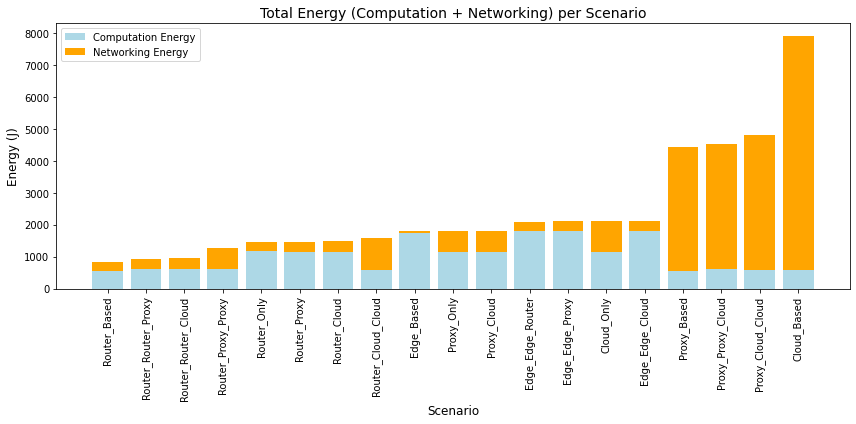

In [15]:
import matplotlib.pyplot as plt

# Define the data
scenarios = sorted_total_energy_df['scenario']
computation_energy = sorted_total_energy_df['total_computation_energy']
networking_energy = sorted_total_energy_df['total_networking_energy']

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(scenarios, computation_energy, label='Computation Energy', color='lightblue')
plt.bar(scenarios, networking_energy, bottom=computation_energy, label='Networking Energy', color='orange')

# Formatting the chart
plt.title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Energy (J)', fontsize=12)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

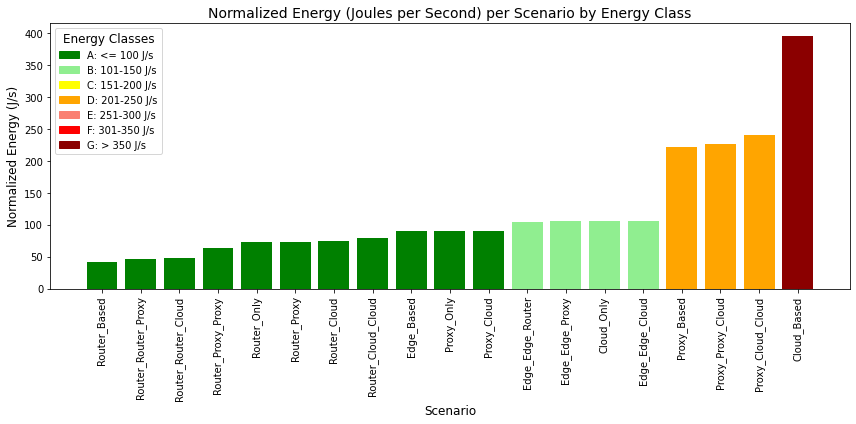

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges (adjust the ranges based on your data)
def assign_energy_class(energy_value):
    if energy_value <= 100:
        return 'A'
    elif 100 < energy_value <= 150:
        return 'B'
    elif 150 < energy_value <= 200:
        return 'C'
    elif 200 < energy_value <= 250:
        return 'D'
    elif 250 < energy_value <= 300:
        return 'E'
    elif 300 < energy_value <= 350:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the classification function to the normalized energy column
sorted_total_energy_df['energy_class'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_energy_class)

# Step 3: Define a color map for the classes
color_map = {
    'A': 'green',
    'B': 'lightgreen',
    'C': 'yellow',
    'D': 'orange',
    'E': 'salmon',
    'F': 'red',
    'G': 'darkred'
}

# Step 4: Assign colors based on energy classes
colors = sorted_total_energy_df['energy_class'].map(color_map)

# Step 5: Plotting the normalized energy bar chart with colors based on energy class
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)

# Step 6: Create a custom legend based on the energy class and color map
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 100 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 101-150 J/s'),
    mpatches.Patch(color='yellow', label='C: 151-200 J/s'),
    mpatches.Patch(color='orange', label='D: 201-250 J/s'),
    mpatches.Patch(color='salmon', label='E: 251-300 J/s'),
    mpatches.Patch(color='red', label='F: 301-350 J/s'),
    mpatches.Patch(color='darkred', label='G: > 350 J/s')
]

# Step 7: Add the legend to the chart
plt.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# Formatting the chart
plt.title('Normalized Energy (Joules per Second) per Scenario by Energy Class', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Normalized Energy (J/s)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


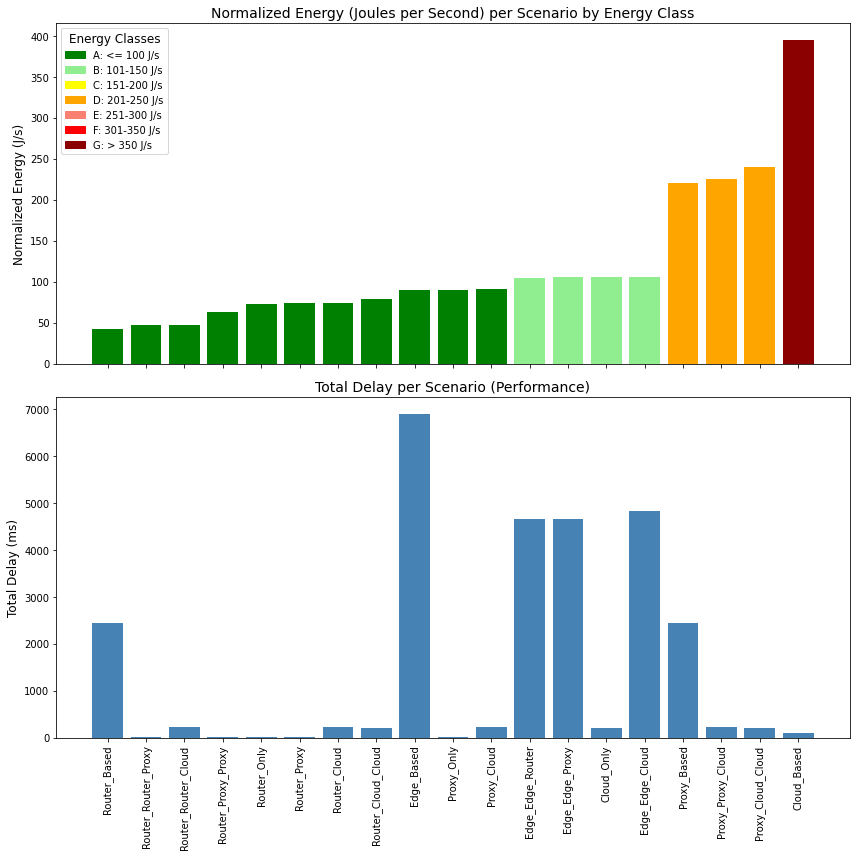

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges (adjust the ranges based on your data)
def assign_energy_class(energy_value):
    if energy_value <= 100:
        return 'A'
    elif 100 < energy_value <= 150:
        return 'B'
    elif 150 < energy_value <= 200:
        return 'C'
    elif 200 < energy_value <= 250:
        return 'D'
    elif 250 < energy_value <= 300:
        return 'E'
    elif 300 < energy_value <= 350:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the classification function to the normalized energy column
sorted_total_energy_df['energy_class'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_energy_class)

# Step 3: Define a color map for the classes
color_map = {
    'A': 'green',
    'B': 'lightgreen',
    'C': 'yellow',
    'D': 'orange',
    'E': 'salmon',
    'F': 'red',
    'G': 'darkred'
}

# Step 4: Assign colors based on energy classes
colors = sorted_total_energy_df['energy_class'].map(color_map)

# Create the figure with two subplots: one for energy and one for total delay (performance)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# ----- Plot 1: Energy chart -----
bars1 = ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Step 5: Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 100 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 101-150 J/s'),
    mpatches.Patch(color='yellow', label='C: 151-200 J/s'),
    mpatches.Patch(color='orange', label='D: 201-250 J/s'),
    mpatches.Patch(color='salmon', label='E: 251-300 J/s'),
    mpatches.Patch(color='red', label='F: 301-350 J/s'),
    mpatches.Patch(color='darkred', label='G: > 350 J/s')
]

# Add the legend for energy classes
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart -----
bars2 = ax2.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_delay'], color='steelblue')
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Step 6: Ensure both plots have the same layout and size
plt.tight_layout()

# Step 7: Show the combined plot with energy on top and performance below
plt.show()


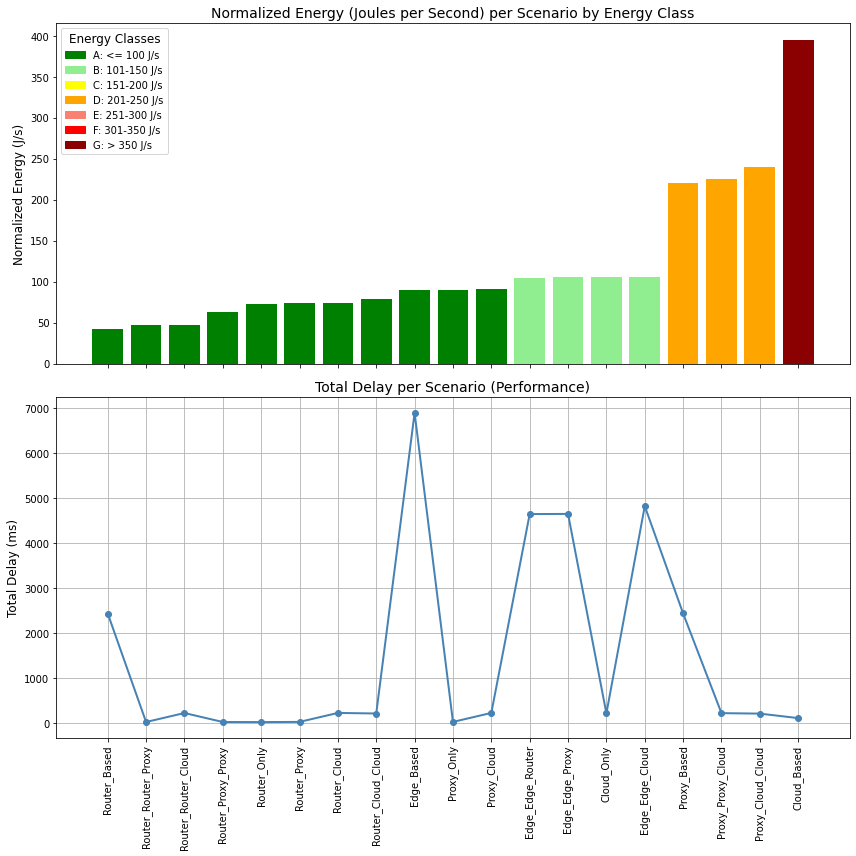

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges (adjust the ranges based on your data)
def assign_energy_class(energy_value):
    if energy_value <= 100:
        return 'A'
    elif 100 < energy_value <= 150:
        return 'B'
    elif 150 < energy_value <= 200:
        return 'C'
    elif 200 < energy_value <= 250:
        return 'D'
    elif 250 < energy_value <= 300:
        return 'E'
    elif 300 < energy_value <= 350:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the classification function to the normalized energy column
sorted_total_energy_df['energy_class'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_energy_class)

# Step 3: Define a color map for the classes
color_map = {
    'A': 'green',
    'B': 'lightgreen',
    'C': 'yellow',
    'D': 'orange',
    'E': 'salmon',
    'F': 'red',
    'G': 'darkred'
}

# Step 4: Assign colors based on energy classes
colors = sorted_total_energy_df['energy_class'].map(color_map)

# Create the figure with two subplots: one for energy (bar chart) and one for total delay (line chart)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# ----- Plot 1: Energy chart (Bar Chart) -----
bars1 = ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Step 5: Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 100 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 101-150 J/s'),
    mpatches.Patch(color='yellow', label='C: 151-200 J/s'),
    mpatches.Patch(color='orange', label='D: 201-250 J/s'),
    mpatches.Patch(color='salmon', label='E: 251-300 J/s'),
    mpatches.Patch(color='red', label='F: 301-350 J/s'),
    mpatches.Patch(color='darkred', label='G: > 350 J/s')
]

# Add the legend for energy classes
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart (Line Chart) -----
ax2.plot(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_delay'], color='steelblue', marker='o', linewidth=2)
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)
ax2.grid(True)  # Optional: Add a grid to the line chart for readability

# Step 6: Ensure both plots have the same layout and size
plt.tight_layout()

# Step 7: Show the combined plot with energy on top and performance (total delay) as a line chart below
plt.show()


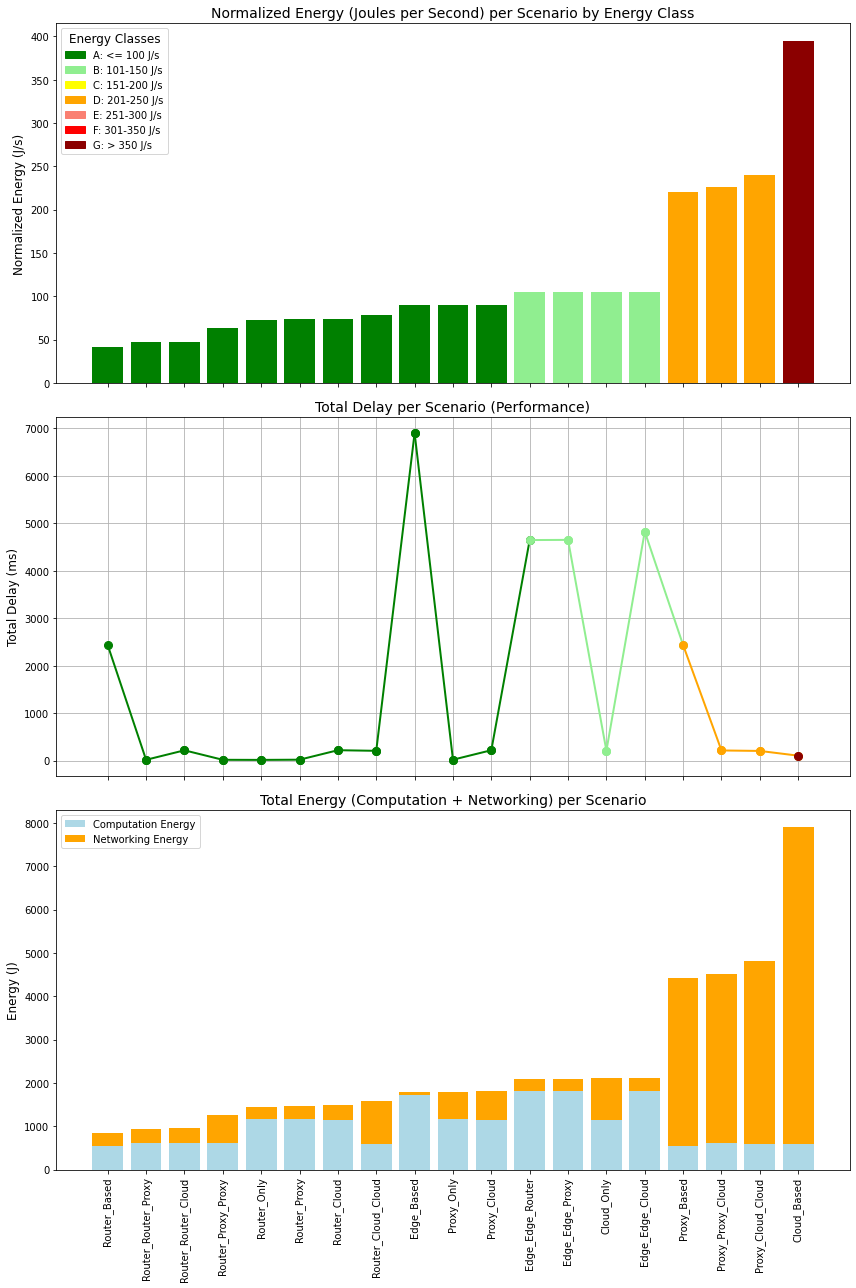

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges (adjust the ranges based on your data)
def assign_energy_class(energy_value):
    if energy_value <= 100:
        return 'A'
    elif 100 < energy_value <= 150:
        return 'B'
    elif 150 < energy_value <= 200:
        return 'C'
    elif 200 < energy_value <= 250:
        return 'D'
    elif 250 < energy_value <= 300:
        return 'E'
    elif 300 < energy_value <= 350:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the classification function to the normalized energy column
sorted_total_energy_df['energy_class'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_energy_class)

# Step 3: Define a color map for the classes
color_map = {
    'A': 'green',
    'B': 'lightgreen',
    'C': 'yellow',
    'D': 'orange',
    'E': 'salmon',
    'F': 'red',
    'G': 'darkred'
}

# Step 4: Assign colors based on energy classes
colors = sorted_total_energy_df['energy_class'].map(color_map)

# Create the figure with three subplots: one for energy (bar chart), one for total delay (line chart), and the last for the stacked energy chart
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# ----- Plot 1: Energy chart (Bar Chart) -----
bars1 = ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Step 5: Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 100 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 101-150 J/s'),
    mpatches.Patch(color='yellow', label='C: 151-200 J/s'),
    mpatches.Patch(color='orange', label='D: 201-250 J/s'),
    mpatches.Patch(color='salmon', label='E: 251-300 J/s'),
    mpatches.Patch(color='red', label='F: 301-350 J/s'),
    mpatches.Patch(color='darkred', label='G: > 350 J/s')
]

# Add the legend for energy classes
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart (Line Chart) -----
# Plot the line chart with colors for both the lines and markers based on energy class
for i in range(len(sorted_total_energy_df) - 1):
    ax2.plot(
        [i, i + 1],
        [sorted_total_energy_df['total_delay'].iloc[i], sorted_total_energy_df['total_delay'].iloc[i + 1]],
        color=colors.iloc[i], marker='o', markersize=8, linestyle='-', linewidth=2
    )

# Plot the last point separately to ensure it is displayed correctly
ax2.plot(len(sorted_total_energy_df) - 1, sorted_total_energy_df['total_delay'].iloc[-1], color=colors.iloc[-1], marker='o', markersize=8)

ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)  # Optional: Add a grid to the line chart for readability

# ----- Plot 3: Stacked Energy Chart (Computation + Networking) -----
scenarios = sorted_total_energy_df['scenario']
computation_energy = sorted_total_energy_df['total_computation_energy']
networking_energy = sorted_total_energy_df['total_networking_energy']

# Plotting the stacked bar chart
bars3 = ax3.bar(scenarios, computation_energy, label='Computation Energy', color='lightblue')
bars3 = ax3.bar(scenarios, networking_energy, bottom=computation_energy, label='Networking Energy', color='orange')

# Formatting the stacked bar chart
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)', fontsize=12)
ax3.legend()

# Set the X-axis ticks (scenarios) for all charts
ax3.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax3.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Step 6: Ensure all three plots have the same layout and size
plt.tight_layout()

# Step 7: Save the combined plot to a PNG file
plt.savefig('combined_energy_performance_charts.png', format='png')

# Step 8: Show the combined plot with energy on top, performance in the middle, and stacked energy at the bottom
plt.show()


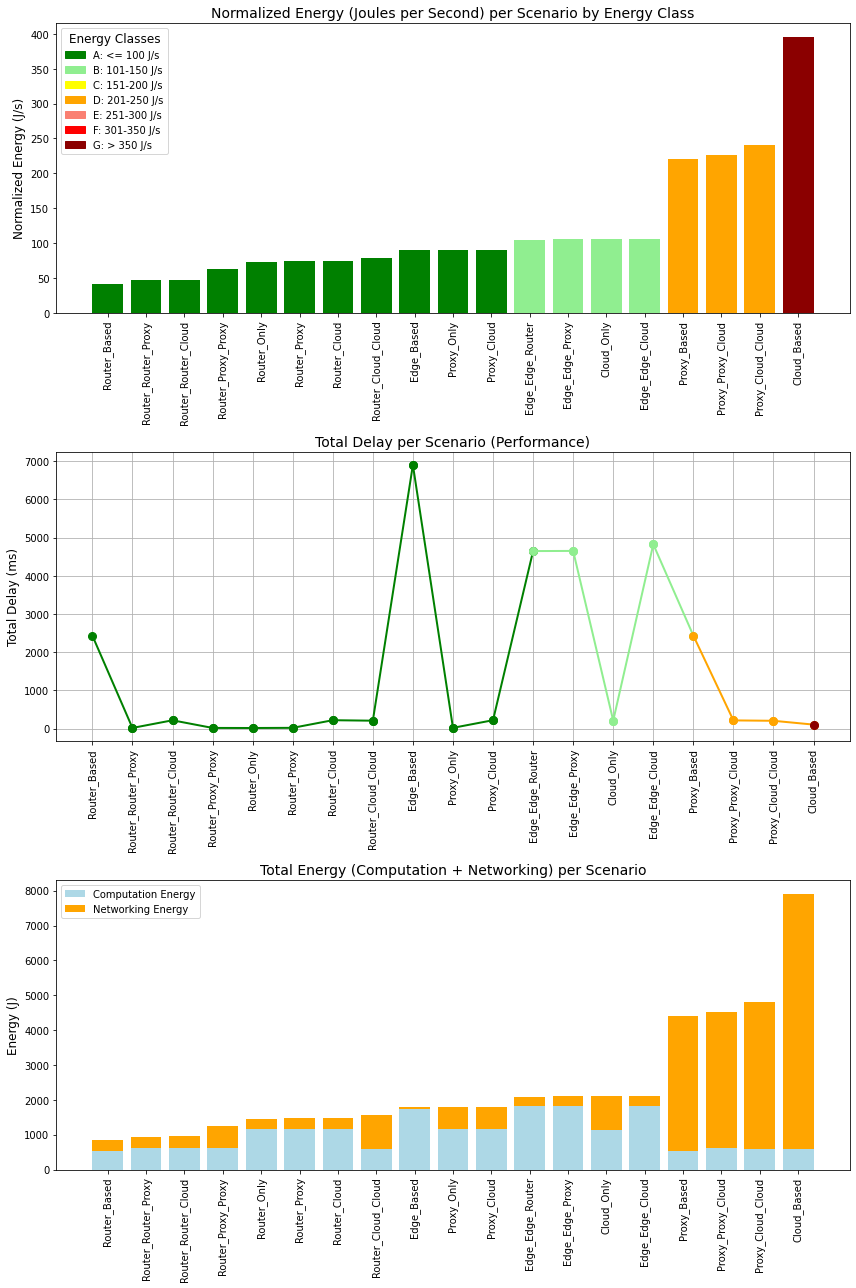

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges (adjust the ranges based on your data)
def assign_energy_class(energy_value):
    if energy_value <= 100:
        return 'A'
    elif 100 < energy_value <= 150:
        return 'B'
    elif 150 < energy_value <= 200:
        return 'C'
    elif 200 < energy_value <= 250:
        return 'D'
    elif 250 < energy_value <= 300:
        return 'E'
    elif 300 < energy_value <= 350:
        return 'F'
    else:
        return 'G'

# Step 2: Apply the classification function to the normalized energy column
sorted_total_energy_df['energy_class'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_energy_class)

# Step 3: Define a color map for the classes
color_map = {
    'A': 'green',
    'B': 'lightgreen',
    'C': 'yellow',
    'D': 'orange',
    'E': 'salmon',
    'F': 'red',
    'G': 'darkred'
}

# Step 4: Assign colors based on energy classes
colors = sorted_total_energy_df['energy_class'].map(color_map)

# Create the figure with three subplots: one for energy (bar chart), one for total delay (line chart), and the last for the stacked energy chart
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Energy chart (Bar Chart) -----
bars1 = ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Step 5: Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: <= 100 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 101-150 J/s'),
    mpatches.Patch(color='yellow', label='C: 151-200 J/s'),
    mpatches.Patch(color='orange', label='D: 201-250 J/s'),
    mpatches.Patch(color='salmon', label='E: 251-300 J/s'),
    mpatches.Patch(color='red', label='F: 301-350 J/s'),
    mpatches.Patch(color='darkred', label='G: > 350 J/s')
]

# Add the legend for energy classes
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) chart (Line Chart) -----
# Plot the line chart with colors for both the lines and markers based on energy class
for i in range(len(sorted_total_energy_df) - 1):
    ax2.plot(
        [i, i + 1],
        [sorted_total_energy_df['total_delay'].iloc[i], sorted_total_energy_df['total_delay'].iloc[i + 1]],
        color=colors.iloc[i], marker='o', markersize=8, linestyle='-', linewidth=2
    )

# Plot the last point separately to ensure it is displayed correctly
ax2.plot(len(sorted_total_energy_df) - 1, sorted_total_energy_df['total_delay'].iloc[-1], color=colors.iloc[-1], marker='o', markersize=8)

ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)  # Optional: Add a grid to the line chart for readability

# ----- Plot 3: Stacked Energy Chart (Computation + Networking) -----
scenarios = sorted_total_energy_df['scenario']
computation_energy = sorted_total_energy_df['total_computation_energy']
networking_energy = sorted_total_energy_df['total_networking_energy']

# Plotting the stacked bar chart
bars3 = ax3.bar(scenarios, computation_energy, label='Computation Energy', color='lightblue')
bars3 = ax3.bar(scenarios, networking_energy, bottom=computation_energy, label='Networking Energy', color='orange')

# Formatting the stacked bar chart
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)', fontsize=12)
ax3.legend()

# ----- Set X-axis labels for all charts -----
# Display X-axis labels for all charts manually
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)
ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)
ax3.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax3.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)


# Step 6: Ensure all three plots have the same layout and size
plt.tight_layout()

# Step 7: Save the combined plot to a PNG file
plt.savefig('combined_energy_performance_charts_fixed.png', format='png')

# Step 8: Show the combined plot with energy on top, performance in the middle, and stacked energy at the bottom
plt.show()




               scenario  normalized_energy_per_sec energy_class_equal_width
0          Router_Based                  41.731206                        A
1   Router_Router_Proxy                  46.979987                        A
2   Router_Router_Cloud                  47.620561                        A
3    Router_Proxy_Proxy                  63.144192                        A
4           Router_Only                  72.673005                        A
5          Router_Proxy                  73.603229                        A
6          Router_Cloud                  74.251462                        A
7    Router_Cloud_Cloud                  78.580768                        A
8            Edge_Based                  89.692608                        A
9            Proxy_Only                  89.767545                        A
10          Proxy_Cloud                  90.406558                        A
11     Edge_Edge_Router                 104.571997                        B
12      Edge

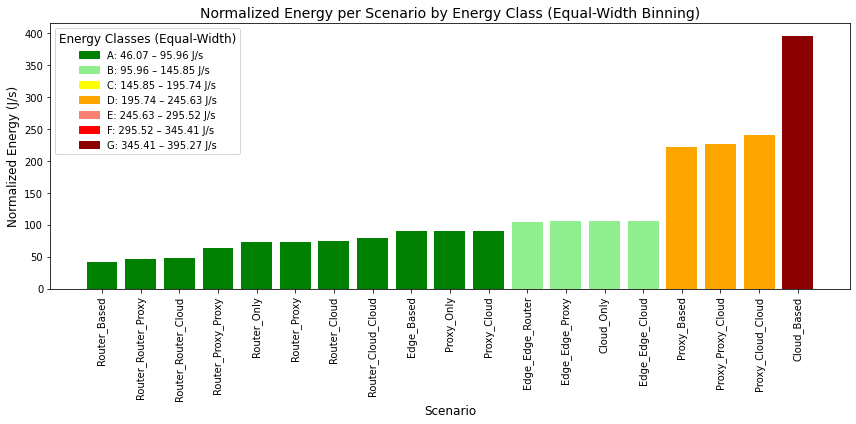

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define the energy class ranges
def assign_equal_width_class(energy_value):
    if energy_value <= 95.96:
        return 'A'
    elif 95.96 < energy_value <= 145.85:
        return 'B'
    elif 145.85 < energy_value <= 195.74:
        return 'C'
    elif 195.74 < energy_value <= 245.63:
        return 'D'
    elif 245.63 < energy_value <= 295.52:
        return 'E'
    elif 295.52 < energy_value <= 345.41:
        return 'F'
    else:
        return 'G'

# Apply equal-width classification to the normalized energy column
sorted_total_energy_df['energy_class_equal_width'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_equal_width_class)

# Display the updated DataFrame with energy classes
print(sorted_total_energy_df[['scenario', 'normalized_energy_per_sec', 'energy_class_equal_width']])

# Visualize the energy class distribution (Equal-Width Binning)
colors = sorted_total_energy_df['energy_class_equal_width'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
})

# Plotting the energy classification (equal-width binning)
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)

# Create a custom legend based on the energy class
legend_patches = [
    mpatches.Patch(color='green', label='A: 46.07 – 95.96 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 95.96 – 145.85 J/s'),
    mpatches.Patch(color='yellow', label='C: 145.85 – 195.74 J/s'),
    mpatches.Patch(color='orange', label='D: 195.74 – 245.63 J/s'),
    mpatches.Patch(color='salmon', label='E: 245.63 – 295.52 J/s'),
    mpatches.Patch(color='red', label='F: 295.52 – 345.41 J/s'),
    mpatches.Patch(color='darkred', label='G: 345.41 – 395.27 J/s')
]

# Add the legend to the chart
plt.legend(handles=legend_patches, title='Energy Classes (Equal-Width)', fontsize=10, title_fontsize=12)

# Formatting the chart
plt.title('Normalized Energy per Scenario by Energy Class (Equal-Width Binning)', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Normalized Energy (J/s)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


               scenario  normalized_energy_per_sec energy_class_percentile
0          Router_Based                  41.731206                       A
1   Router_Router_Proxy                  46.979987                       A
2   Router_Router_Cloud                  47.620561                       B
3    Router_Proxy_Proxy                  63.144192                       B
4           Router_Only                  72.673005                       B
5          Router_Proxy                  73.603229                       C
6          Router_Cloud                  74.251462                       C
7    Router_Cloud_Cloud                  78.580768                       C
8            Edge_Based                  89.692608                       C
9            Proxy_Only                  89.767545                       C
10          Proxy_Cloud                  90.406558                       D
11     Edge_Edge_Router                 104.571997                       D
12      Edge_Edge_Proxy  

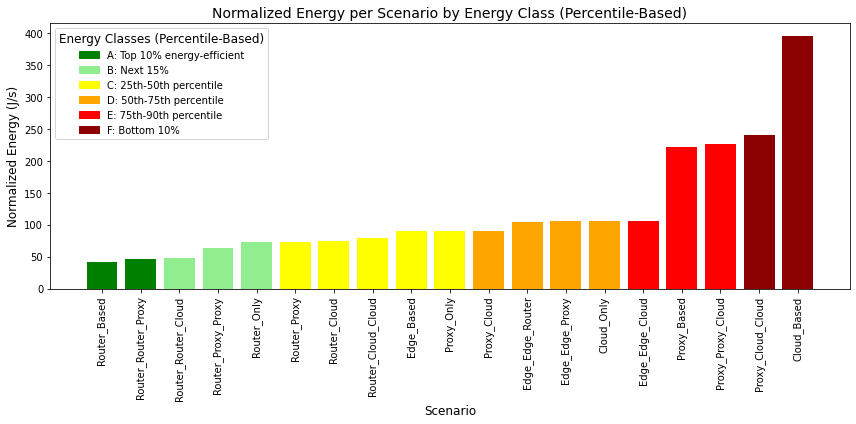

In [22]:
# Step 1: Define percentiles for classification
percentiles = [10, 25, 50, 75, 90]

# Step 2: Calculate the percentile thresholds
percentile_thresholds = np.percentile(sorted_total_energy_df['normalized_energy_per_sec'], percentiles)

# Step 3: Assign energy classes based on percentiles
def assign_percentile_class(energy_value):
    if energy_value <= percentile_thresholds[0]:
        return 'A'
    elif percentile_thresholds[0] < energy_value <= percentile_thresholds[1]:
        return 'B'
    elif percentile_thresholds[1] < energy_value <= percentile_thresholds[2]:
        return 'C'
    elif percentile_thresholds[2] < energy_value <= percentile_thresholds[3]:
        return 'D'
    elif percentile_thresholds[3] < energy_value <= percentile_thresholds[4]:
        return 'E'
    else:
        return 'F'

# Apply percentile-based classification to the normalized energy column
sorted_total_energy_df['energy_class_percentile'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_percentile_class)

# Display the updated DataFrame with energy classes
print(sorted_total_energy_df[['scenario', 'normalized_energy_per_sec', 'energy_class_percentile']])

# Visualize the energy class distribution (Percentile-Based Binning)
colors = sorted_total_energy_df['energy_class_percentile'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'red', 'F': 'darkred'
})

# Plotting the energy classification (percentile-based binning)
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)

# Create a custom legend based on the energy class
legend_patches = [
    mpatches.Patch(color='green', label='A: Top 10% energy-efficient'),
    mpatches.Patch(color='lightgreen', label='B: Next 15%'),
    mpatches.Patch(color='yellow', label='C: 25th-50th percentile'),
    mpatches.Patch(color='orange', label='D: 50th-75th percentile'),
    mpatches.Patch(color='red', label='E: 75th-90th percentile'),
    mpatches.Patch(color='darkred', label='F: Bottom 10%')
]

# Add the legend to the chart
plt.legend(handles=legend_patches, title='Energy Classes (Percentile-Based)', fontsize=10, title_fontsize=12)

# Formatting the chart
plt.title('Normalized Energy per Scenario by Energy Class (Percentile-Based)', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Normalized Energy (J/s)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


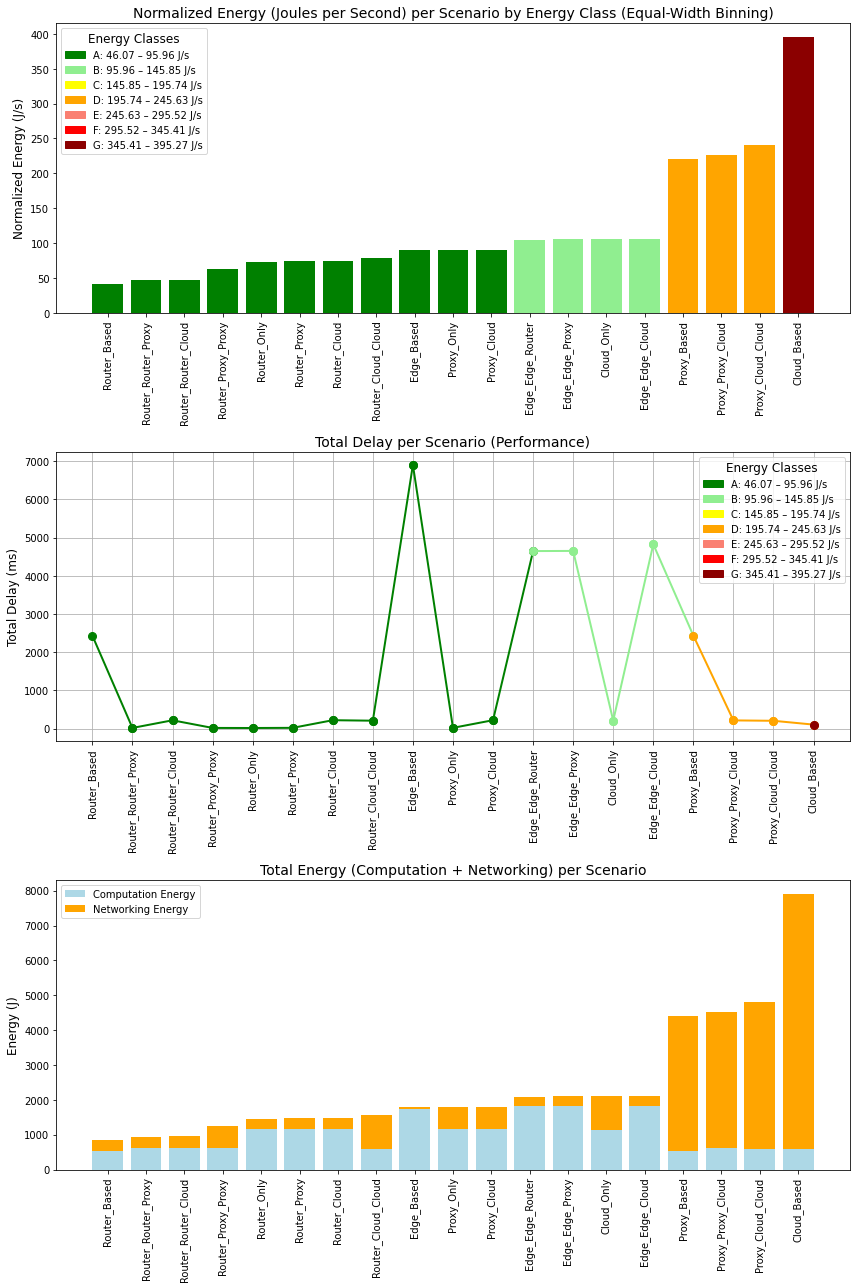

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Define the energy class ranges for equal-width binning
def assign_equal_width_class(energy_value):
    if energy_value <= 95.96:
        return 'A'
    elif 95.96 < energy_value <= 145.85:
        return 'B'
    elif 145.85 < energy_value <= 195.74:
        return 'C'
    elif 195.74 < energy_value <= 245.63:
        return 'D'
    elif 245.63 < energy_value <= 295.52:
        return 'E'
    elif 295.52 < energy_value <= 345.41:
        return 'F'
    else:
        return 'G'

# Apply equal-width classification to the normalized energy column
sorted_total_energy_df['energy_class_equal_width'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_equal_width_class)

# Assign colors based on energy class
colors = sorted_total_energy_df['energy_class_equal_width'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
})

# Create figure with 3 subplots (without sharex=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Normalized Energy Chart (Bar Chart) -----
ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class (Equal-Width Binning)', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: 46.07 – 95.96 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 95.96 – 145.85 J/s'),
    mpatches.Patch(color='yellow', label='C: 145.85 – 195.74 J/s'),
    mpatches.Patch(color='orange', label='D: 195.74 – 245.63 J/s'),
    mpatches.Patch(color='salmon', label='E: 245.63 – 295.52 J/s'),
    mpatches.Patch(color='red', label='F: 295.52 – 345.41 J/s'),
    mpatches.Patch(color='darkred', label='G: 345.41 – 395.27 J/s')
]
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) Chart (Line Chart with Colored Lines) -----
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)

# Plot the delay using the colors based on energy class and also connect the lines
for i in range(len(sorted_total_energy_df) - 1):
    ax2.plot(
        [i, i + 1],
        [sorted_total_energy_df['total_delay'].iloc[i], sorted_total_energy_df['total_delay'].iloc[i + 1]],
        color=colors.iloc[i], marker='o', markersize=8, linestyle='-', linewidth=2
    )

# Plot the last point separately to ensure it is displayed correctly
ax2.plot(len(sorted_total_energy_df) - 1, sorted_total_energy_df['total_delay'].iloc[-1], color=colors.iloc[-1], marker='o', markersize=8)

# Update the legend to match the colors from energy classes
ax2.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)
# ----- Plot 3: Total Energy (Stacked Bar Chart) -----
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_computation_energy'], label='Computation Energy', color='lightblue')
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_networking_energy'], bottom=sorted_total_energy_df['total_computation_energy'], label='Networking Energy', color='orange')
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)', fontsize=12)
ax3.legend()

# Set individual X-axis labels (Scenario names) for each subplot
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax3.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax3.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Apply tight layout to ensure everything fits well
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('combined_energy_performance_charts_Equal-Width.png')

# Show the plot
plt.show()


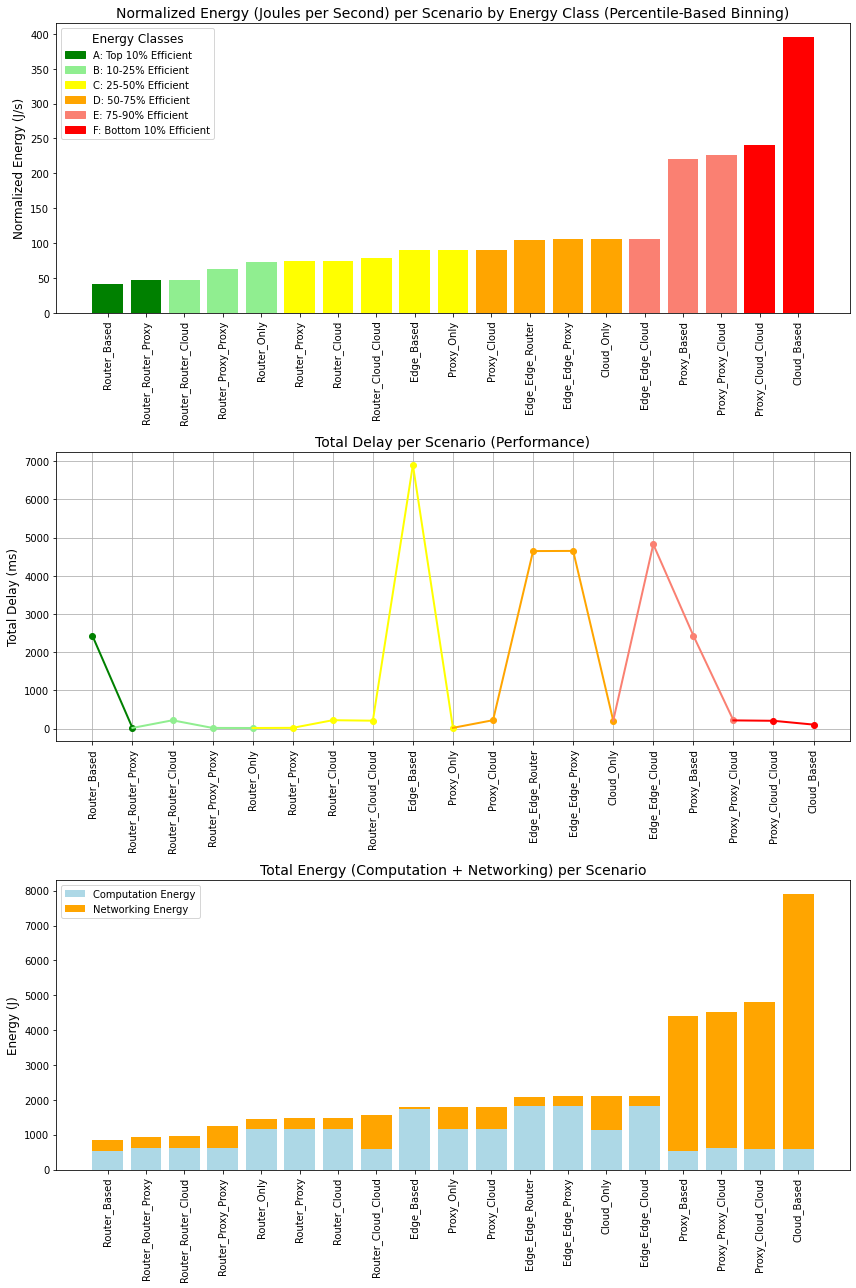

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Calculate the percentiles for percentile-based binning
percentiles = [10, 25, 50, 75, 90]
percentile_thresholds = np.percentile(sorted_total_energy_df['normalized_energy_per_sec'], percentiles)

def assign_percentile_class(energy_value):
    if energy_value <= percentile_thresholds[0]:
        return 'A'
    elif percentile_thresholds[0] < energy_value <= percentile_thresholds[1]:
        return 'B'
    elif percentile_thresholds[1] < energy_value <= percentile_thresholds[2]:
        return 'C'
    elif percentile_thresholds[2] < energy_value <= percentile_thresholds[3]:
        return 'D'
    elif percentile_thresholds[3] < energy_value <= percentile_thresholds[4]:
        return 'E'
    else:
        return 'F'

# Apply percentile-based classification to the normalized energy column
sorted_total_energy_df['energy_class_percentile'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_percentile_class)

# Assign colors based on energy class
colors = sorted_total_energy_df['energy_class_percentile'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red'
})

# Create figure with 3 subplots (without sharex=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Normalized Energy Chart (Bar Chart) -----
ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Normalized Energy (Joules per Second) per Scenario by Energy Class (Percentile-Based Binning)', fontsize=14)
ax1.set_ylabel('Normalized Energy (J/s)', fontsize=12)

# Create a custom legend for energy classes (percentile-based)
legend_patches = [
    mpatches.Patch(color='green', label='A: Top 10% Efficient'),
    mpatches.Patch(color='lightgreen', label='B: 10-25% Efficient'),
    mpatches.Patch(color='yellow', label='C: 25-50% Efficient'),
    mpatches.Patch(color='orange', label='D: 50-75% Efficient'),
    mpatches.Patch(color='salmon', label='E: 75-90% Efficient'),
    mpatches.Patch(color='red', label='F: Bottom 10% Efficient')
]
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) Chart (Line Chart with Colored Lines) -----
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)
ax2.grid(True)

# Plot the delay using the colors based on energy class and also connect the lines
for i, scenario in enumerate(sorted_total_energy_df['scenario']):
    ax2.plot(scenario, sorted_total_energy_df['total_delay'].iloc[i], color=colors.iloc[i], marker='o', linewidth=2)
    if i > 0:
        ax2.plot([sorted_total_energy_df['scenario'].iloc[i-1], scenario],
                 [sorted_total_energy_df['total_delay'].iloc[i-1], sorted_total_energy_df['total_delay'].iloc[i]],
                 color=colors.iloc[i], linewidth=2)

# ----- Plot 3: Total Energy (Stacked Bar Chart) -----
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_computation_energy'], label='Computation Energy', color='lightblue')
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_networking_energy'], bottom=sorted_total_energy_df['total_computation_energy'], label='Networking Energy', color='orange')
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)', fontsize=12)
ax3.legend()

# Set individual X-axis labels (Scenario names) for each subplot
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax3.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax3.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Apply tight layout to ensure everything fits well
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('combined_energy_performance_charts_Percentile.png')

# Show the plot
plt.show()


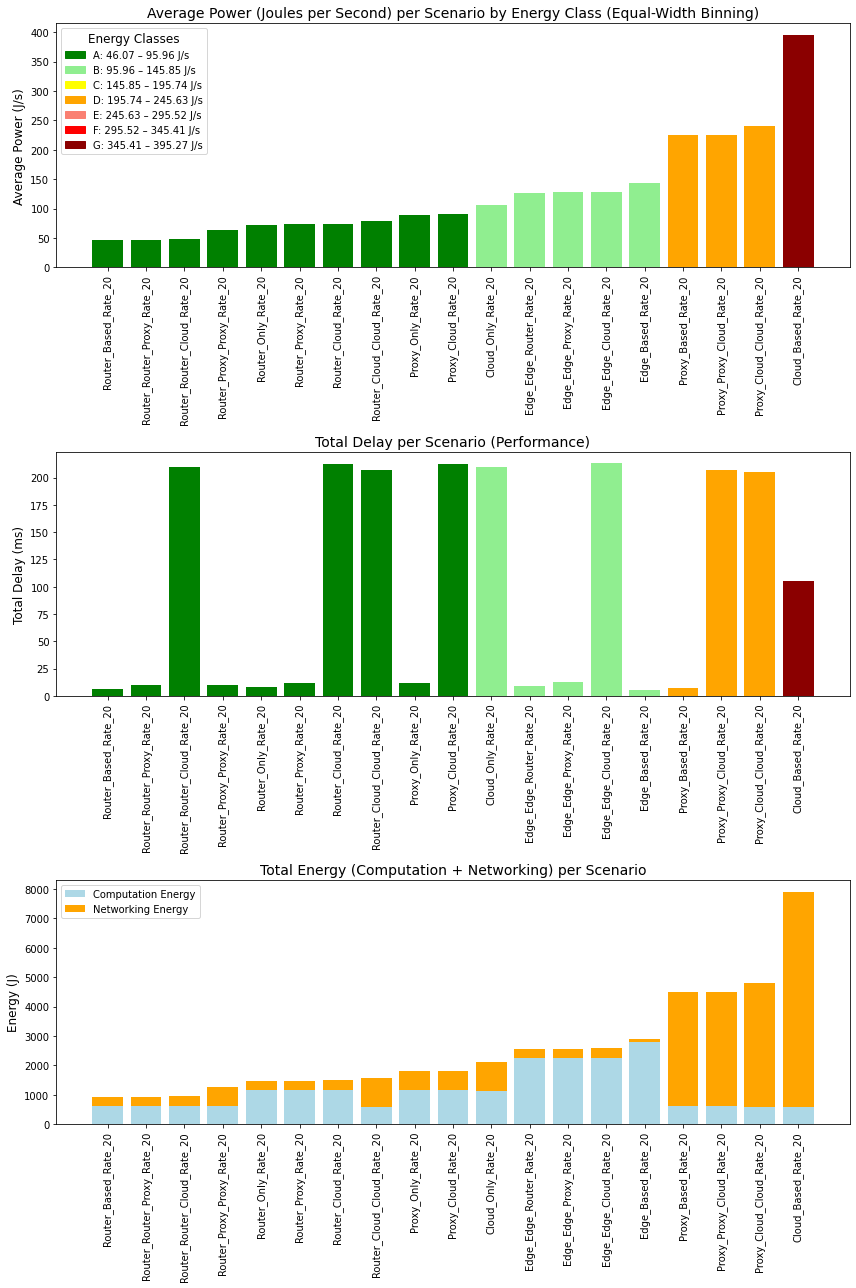

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Step 1: Load the data into a DataFrame
file_path = '/media/saeedeh/Data/PhD/Simulators/iFog_Simulator/IFogSim/Report_Saeedeh/Rate_20_normalized_total_energy_per_scenario.xlsx'

data_df = pd.read_excel(file_path)

# Step 2: Sort the DataFrame based on the 'normalized_energy_per_sec' column
sorted_total_energy_df = data_df.sort_values(by='normalized_energy_per_sec').reset_index(drop=True)

# Step 3: Define the energy class ranges for equal-width binning
def assign_equal_width_class(energy_value):
    if energy_value <= 95.96:
        return 'A'
    elif 95.96 < energy_value <= 145.85:
        return 'B'
    elif 145.85 < energy_value <= 195.74:
        return 'C'
    elif 195.74 < energy_value <= 245.63:
        return 'D'
    elif 245.63 < energy_value <= 295.52:
        return 'E'
    elif 295.52 < energy_value <= 345.41:
        return 'F'
    else:
        return 'G'

# Step 4: Apply equal-width classification to the normalized energy column
sorted_total_energy_df['energy_class_equal_width'] = sorted_total_energy_df['normalized_energy_per_sec'].apply(assign_equal_width_class)

# Step 5: Assign colors based on energy class
colors = sorted_total_energy_df['energy_class_equal_width'].map({
    'A': 'green', 'B': 'lightgreen', 'C': 'yellow', 'D': 'orange', 'E': 'salmon', 'F': 'red', 'G': 'darkred'
})

# Step 6: Create figure with 3 subplots (without sharex=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# ----- Plot 1: Average Power (Bar Chart) -----
ax1.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['normalized_energy_per_sec'], color=colors)
ax1.set_title('Average Power (Joules per Second) per Scenario by Energy Class (Equal-Width Binning)', fontsize=14)
ax1.set_ylabel('Average Power (J/s)', fontsize=12)  # Changed label to "Average Power"

# Create a custom legend for energy classes
legend_patches = [
    mpatches.Patch(color='green', label='A: 46.07 – 95.96 J/s'),
    mpatches.Patch(color='lightgreen', label='B: 95.96 – 145.85 J/s'),
    mpatches.Patch(color='yellow', label='C: 145.85 – 195.74 J/s'),
    mpatches.Patch(color='orange', label='D: 195.74 – 245.63 J/s'),
    mpatches.Patch(color='salmon', label='E: 245.63 – 295.52 J/s'),
    mpatches.Patch(color='red', label='F: 295.52 – 345.41 J/s'),
    mpatches.Patch(color='darkred', label='G: 345.41 – 395.27 J/s')
]
ax1.legend(handles=legend_patches, title='Energy Classes', fontsize=10, title_fontsize=12)

# ----- Plot 2: Performance (Total Delay) Chart (Bar Chart) -----
ax2.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_delay'], color=colors)
ax2.set_title('Total Delay per Scenario (Performance)', fontsize=14)
ax2.set_ylabel('Total Delay (ms)', fontsize=12)

# Removed the legend from the second chart (ax2)
# ax2.legend() has been removed

# ----- Plot 3: Total Energy (Stacked Bar Chart) -----
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_computation_energy'], label='Computation Energy', color='lightblue')
ax3.bar(sorted_total_energy_df['scenario'], sorted_total_energy_df['total_networking_energy'], bottom=sorted_total_energy_df['total_computation_energy'], label='Networking Energy', color='orange')
ax3.set_title('Total Energy (Computation + Networking) per Scenario', fontsize=14)
ax3.set_ylabel('Energy (J)', fontsize=12)
ax3.legend()

# Set individual X-axis labels (Scenario names) for each subplot
ax1.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax1.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax2.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax2.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

ax3.set_xticks(range(len(sorted_total_energy_df['scenario'])))
ax3.set_xticklabels(sorted_total_energy_df['scenario'], rotation=90)

# Apply tight layout to ensure everything fits well
plt.tight_layout()

# Save the figure as a PNG file (Removed 'Normalized' from file name)
plt.savefig('combined_energy_performance_charts_Equal-Width.png')

# Show the plot
plt.show()
